# ***Random Orbits starting at periapsis - one period, variable dt, dp = 800***

In [ ]:
import sys
import pickle
import torch
import math
import numpy as np
from random import randint, uniform
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib as mpl  


def jPerturb(rvec, num, MU_EARTH):
    """
    Computes the J2_EARTH-J6_EARTH zonal gravitational perturbation
    accelerations.

    :param rvec: Cartesian Position vector in kilometers [x;y;z].
    :param num: Corresponds to which J components to use,
                must be an integer between 2 and 6.
                (note: Additive- 2 corresponds to J2_EARTH while 3 will
                correspond to J2_EARTH + J3_EARTH)
    :param planet: planet variable, can be
                 CELESTIAL_MERCURY
                 CELESTIAL_VENUS
                 CELESTIAL_EARTH
                 CELESTIAL_MOON
                 CELESTIAL_MARS
                 CELESTIAL_JUPITER
                 CELESTIAL_URANUS
                 CELESTIAL_NEPTUNE
    :return: ajtot, The total acceleration vector due to the J
                    perturbations in km/sec^2 [accelx;accely;accelz]
    """

    ajtot = np.zeros(3)

    # default #
    mu = MU_EARTH
    req = 6378.1366
    J2 = 1082.616e-6
    J3 = -2.53881e-6
    J4 = -1.65597e-6
    J5 = -0.15e-6
    J6 = 0.57e-6


    # Calculate the J perturbations #
    x = rvec[0]
    y = rvec[1]
    z = rvec[2]
    r = LA.norm(rvec)

    # Error Checking #
    if num < 2 or num > 6:
        raise ValueError("ERROR: jPerturb() received num = {}.The value of num should be 2 <= num <= 6.".format(str(num)))

    # Calculating the total acceleration based on user input #
    ajtot = torch.tensor([(1.0 - 5.0 * math.pow(z / r, 2.0)) * (x / r),
                        (1.0 - 5.0 * math.pow(z / r, 2.0)) * (y / r),
                        (3.0 - 5.0 * math.pow(z / r, 2.0)) * (z / r)])
    ajtot = (-3.0 / 2.0 * J2 * (mu / math.pow(r, 2.0)) * math.pow(req / r, 2.0)) * ajtot
    return ajtot

def solarRad(A, m, sunvec, pos):
    """
    Computes the inertial solar radiation force vectors
    based on cross-sectional Area and mass of the spacecraft
    and the position vector of the planet to the sun.

    .. note::

        It is assumed that the solar radiation pressure decreases quadratically with distance from sun (in AU)

    Solar Radiation Equations obtained from
    Earth Space and Planets Journal Vol. 51, 1999 pp. 979-986

    :param A: Cross-sectional area of the spacecraft that is facing the sun in m^2.
    :param m: The mass of the spacecraft in kg.
    :param sunvec: Position vector to the Sun in units of AU. Earth has a distance of 1 AU.
    :return:   arvec, The inertial acceleration vector due to the effects of Solar Radiation pressure in km/sec^2.  The vector
               components of the output are the same as the vector
               components of the sunvec input vector.
    """
    # Solar Radiation Flux #
    flux = 1372.5398

    # Speed of light #
    c = 299792458.

    # Radiation pressure coefficient #
    Cr = 1.3

    # Magnitude of position vector #
    sundist = LA.norm(sunvec)

    # Computing the acceleration vector #
    arvec = ((-Cr * A * flux) / (m * c * math.pow(sundist, 3)) / 1000.) * sunvec

    if pos[0] > 0 and pos[1] > -6378 and pos[1] < 6378:
        arvec = torch.zeros(3,1)

    return arvec

def TBPdyn(t,x,mu, perturb):
    # mu = 398571 # [km^3*s^-2]
    r = torch.sqrt(x[0,0]**2 + x[1,0]**2) # magnitude of position vector
    ax = -mu*x[0,0]/r**3 # acceleration in x-dir based on two-body problem
    ay = -mu*x[1,0]/r**3 # acceleration in y-dir based on two-body problem   

    if perturb:
        pos = torch.tensor([[x[0,0]], [x[1,0]], [0]]) 
        j2_acc = jPerturb(pos, 2, mu)
        srp_acc = solarRad(5,1000, torch.tensor([[-1],[0],[0]]),pos)
        ax_total = ax + j2_acc[0] + srp_acc[0]
        ay_total = ay + j2_acc[1] + srp_acc[1]
    else:
        ax_total = ax
        ay_total = ay

    fdyn = torch.tensor([[x[2]], [x[3]], [ax_total], [ay_total]])
    return fdyn

# runge-kutta fourth-order numerical integration
def rk4(func, tk, yk, mu, perturb, dt, *args):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, yk, mu, perturb, *args)
    f2 = func(tk + dt / 2, yk + (f1 * (dt / 2)), mu, perturb, *args)
    f3 = func(tk + dt / 2, yk + (f2 * (dt / 2)), mu, perturb, *args)
    f4 = func(tk + dt, yk + (f3 * dt), mu, perturb, *args)

    # return an average of the derivative over tk, tk + dt
    ykp1 = yk + (dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)
    return ykp1


device = torch.device("cuda:0")

number_of_initial_conditions = 200
dp = 800
nx = 4 # state space representation of the model has 4 states
m = 2 # number of control states
predict_time = 25
perturb = 0

# creating empty vectors to store data
data_x = np.empty(number_of_initial_conditions, dtype=object)
data_y = np.empty(number_of_initial_conditions, dtype=object)
data_y2 = np.empty(number_of_initial_conditions, dtype=object)

# looping through all the initial conditions
for num in range(number_of_initial_conditions):

    # Two Body Problem parameters
    G = 6.6742e-20 # Gravitational constant [km^3*kg^-1*s^-2]
    r_Earth = 6378.14  # Average radius of Earth [km]
    m1 = 5.974e24 # mass of Earth [kg]
    m2 = 1000 # mass of satellite [kg]
    mu = G*(m1 + m2) # gravitational parameter [km^3*s^-2]

    # ~~~~~~~~~~~~~~~ Orbital Dynamics Elliptical ~~~~~~~~~~~~~~~# 
    e = 0
    rp = r_Earth + randint(200, 5000) # radius of Perigee [km]
    ra = (rp + e*rp)/(1-e)
    a = (rp + ra)/2 # Semi-Major axis [km]
    period = 2*torch.pi*(a**3/mu)**0.5 # Period of Orbit

    # initial condition (start at periapsis)
    x = rp
    y = 0
    x_dot = 0
    y_dot = (mu*((2/rp) - (1/a)))**0.5
    
    x0_2D = torch.tensor([[x], [y], [x_dot], [y_dot]])
    time = torch.linspace(0, int(period), dp) # simulate for dp=1000 data points
    dt = int(period)/dp
    xk = x0_2D
    X = torch.empty([nx,0])
    Y = torch.empty([nx,0])

    for t in time:
        X = torch.hstack((X, xk))
        xk = rk4(TBPdyn, t, xk, mu, perturb, dt) # RK4 approximation of solution
        Y = torch.hstack((Y, xk))

    X = torch.FloatTensor(X)
    Y = torch.FloatTensor(Y)

    newx = X[:,1:-(predict_time-1)]
    newy2 = Y[:,predict_time:]
    newy = Y[:,1:-(predict_time-1)]

    # storing in one large data array]
    data_x[num] = newx
    data_y[num] = newy
    data_y2[num] = newy2

# min_i = torch.argmin(data_x[:,0,0])
# max_i = torch.argmax(data_x[:,0,0])

# training_lim = torch.stack((data_x[min_i,:,0:2], data_x[max_i,:,0:2]),dim=2)

dp = dp - (predict_time-1)
with open('twobody_data_variables.pkl', 'wb') as f:
    pickle.dump([dp,dt,nx,m,predict_time,e], f)
torch.save(data_x, "X_Data.pt")
torch.save(data_y, "Y_Data.pt")
torch.save(data_y2, "Y2_Data.pt")
# torch.save(training_lim, "Training_PlotE.pt")

In [31]:
# import pickle
# import torch
# import time
# from random import uniform, randint
# import multiprocessing as mp
# from functools import partial
# import matplotlib.pyplot as plt
# import matplotlib as mpl 

# seed = 0
# torch.manual_seed(seed)

# mu = 398571  # [km^3*s^-2]
# r_Earth = 6378.14  # Average radius of Earth [km]

# nx = 4 # state space representation of the model has 4 states
# m = 2 # number of control states
# predict_time = 50#25
# tf = 10000 # Period of Orbit
# dt = 10


# def TBPdyn(t,x,mu):
#     # mu = 398571 # [km^3*s^-2]
#     r = torch.sqrt(x[0,0]**2 + x[1,0]**2) # magnitude of position vector
#     ax = -mu*x[0,0]/r**3 # acceleration in x-dir based on two-body problem
#     ay = -mu*x[1,0]/r**3 # acceleration in y-dir based on two-body problem

#     fdyn = torch.tensor([[x[2]], [x[3]], [ax], [ay]])
#     return fdyn

# # runge-kutta fourth-order numerical integration
# def rk4(func, tk, yk, mu, dt, *args):
#     """
#     single-step fourth-order numerical integration (RK4) method
#     func: system of first order ODEs
#     tk: current time step
#     _yk: current state vector [y1, y2, y3, ...]
#     _dt: discrete time step size
#     **kwargs: additional parameters for ODE system
#     returns: y evaluated at time k+1
#     """

#     # evaluate derivative at several stages within time interval
#     f1 = func(tk, yk, mu, *args)
#     f2 = func(tk + dt / 2, yk + (f1 * (dt / 2)), mu, *args)
#     f3 = func(tk + dt / 2, yk + (f2 * (dt / 2)), mu, *args)
#     f4 = func(tk + dt, yk + (f3 * dt), mu, *args)

#     # return an average of the derivative over tk, tk + dt
#     ykp1 = yk + (dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)
#     return ykp1

# def generate_data(circ,itr):
#     # ~~~~~~~~~~~~~~~ Orbital Dynamics Elliptical ~~~~~~~~~~~~~~~#
#     if circ == 0:
#         e = 0
#     else:
#         # e = uniform(0,0.05) # eccentricity of chief orbit
#         e = 0.2
#     rp = r_Earth + randint(200, 5000) # radius of Perigee [km]
#     ra = (rp + e*rp)/(1-e) # radius of Apogee [km]
#     a = (rp + ra)/2 # Semi-Major axis [km]
#     period = 2*torch.pi*(a**3/mu)**0.5 # Period of Orbit

#     xc0 = rp
#     yc0 = 0
#     xc0_dot = 0
#     yc0_dot = (mu*((2/rp) - (1/a)))**0.5
    
#     x_c0 = torch.tensor([[xc0], [yc0], [xc0_dot], [yc0_dot]])
#     time = torch.arange(0, 1000, dt) # simulate for dp=1000 data points
#     x_c = x_c0
#     X = torch.empty([nx,0])
#     Y = torch.empty([nx,0])

#     for t in time:
#         X = torch.hstack((X, x_c))
#         x_c = rk4(TBPdyn, t, x_c, mu, dt)
#         Y = torch.hstack((Y, x_c))

#     print("Trajectory Complete\n", flush=True)
#     return X[:,:-(predict_time)], Y[:,:-(predict_time)], Y[:,predict_time:]

# def mp_datagen(num_traj):
#     try:
#         with mp.Pool(mp.cpu_count()) as pool:
#             # Distribute the task of generating trajectories across the worker processes
#             # results = pool.map(partial(generate_data,0), range(num_traj))
#             results_e = pool.map(partial(generate_data,1), range(num_traj))
#             # data_x, data_y, data_y2 = zip(*results+results_e)
#             data_x, data_y, data_y2 = zip(*results_e)

#         with open('twobody_data_variables_ellip1.pkl', 'wb') as f:
#             pickle.dump([dt,nx,m,predict_time], f)
#         torch.save(data_x, "X_DataE1.pt")
#         torch.save(data_y, "Y_DataE1.pt")
#         torch.save(data_y2, "Y2_DataE1.pt")

#     finally:
#         pool.close()
#         pool.terminate()
#         pool.join()

# device = torch.device("cuda:0")
# num_traj = 2000
# start_time = time.time()
# mp_datagen(num_traj)
# end_time = time.time()
# elapsed = end_time-start_time
# print(f"Elapsed Time: {elapsed} seconds")

tensor(-0.0051)tensor(-0.0092)tensor(-0.0054)tensor(-0.0053)tensor(-0.0032)tensor(-0.0032)tensor(-0.0059)tensor(-0.0067)tensor(-0.0072)tensor(-0.0046)tensor(-0.0089)tensor(-0.0091)
tensor(-0.0081)
tensor(-0.0081)


tensor(-0.0050)

tensor(-0.0064)tensor(-0.0079)tensor(-0.0031)

tensor(-0.0041)

tensor(-0.0048)
tensor(-0.0032)
tensor(-0.0092)tensor(-0.0049)tensor(-0.0043)
tensor(-0.0051)tensor(-0.0032)tensor(-0.0054)
tensor(-0.0032)
tensor(-0.0053)
tensor(-0.0067)
tensor(-0.0059)
tensor(-0.0072)tensor(-0.0046)
tensor(-0.0089)

tensor(-0.0091)tensor(-0.0081)



tensor(-0.0081)

tensor(-0.0050)
tensor(-0.0064)
tensor(-0.0079)
tensor(-0.0031)
tensor(-0.0041)

tensor(-0.0048)tensor(-0.0092)

tensor(-0.0032)tensor(-0.0043)tensor(-0.0049)
tensor(-0.0032)tensor(-0.0051)tensor(-0.0054)
tensor(-0.0032)
tensor(-0.0053)

tensor(-0.0067)tensor(-0.0059)
tensor(-0.0072)tensor(-0.0046)
tensor(-0.0089)

tensor(-0.0091)
tensor(-0.0081)



tensor(-0.0081)tensor(-0.0050)
tensor(-0.0056)tensor(-0.0064)

te

KeyboardInterrupt: 

# ***Test of training data metrics***

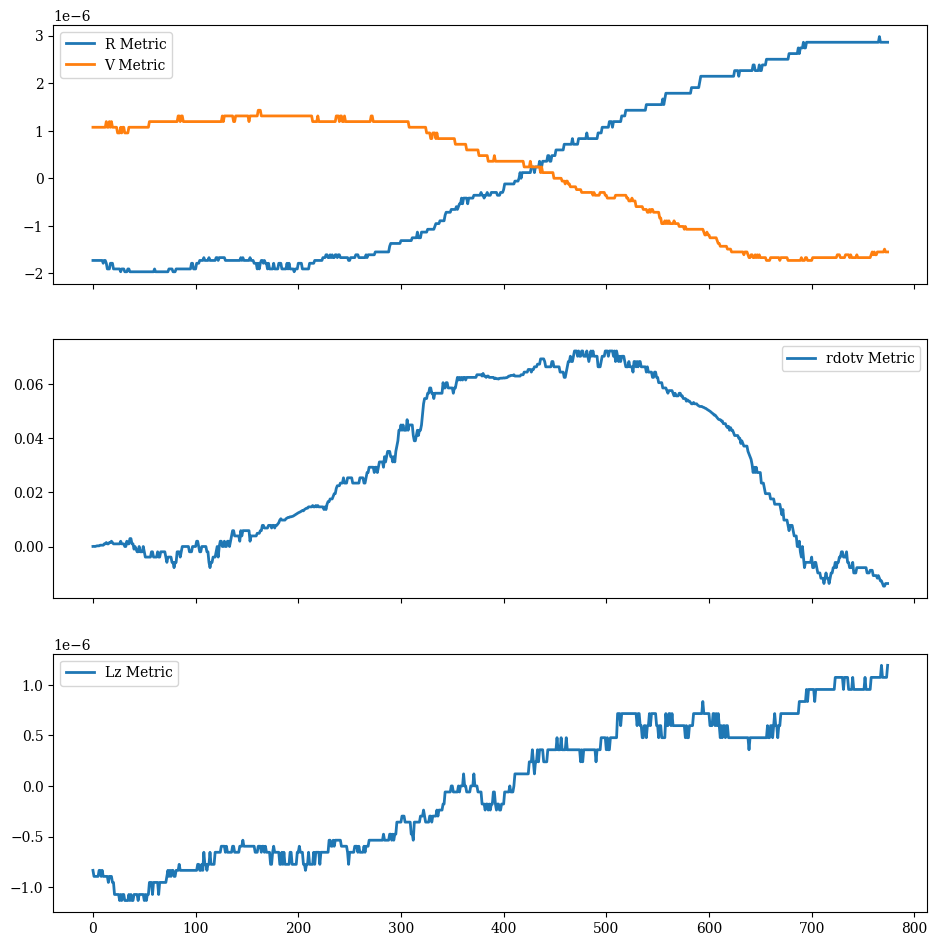

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
data_x = torch.load('X_Data.pt', weights_only=False)
int = data_x[1]
x = int[0,:]
y = int[1,:]
xdot = int[2,:]
ydot = int[3,:]

r = (x**2 + y**2)**0.5
r_avg =torch.mean(r)
r_metric = r/r_avg - 1

v = (xdot**2 + ydot**2)**0.5
v_avg = torch.mean(v)
v_metric = v/v_avg - 1

rdotv = x*xdot + y*ydot
rdotv_avg = torch.mean(rdotv)
rdotv_metric = rdotv/rdotv_avg - 1

Lz = x*ydot - y*xdot
Lz_avg = torch.mean(Lz)
Lz_metric = Lz/Lz_avg - 1

mpl.rc('font',family='Serif')
fig, ax = plt.subplots(3, 1, sharex = 'col', sharey = 'row', figsize = (10, 10))
fig.tight_layout(pad = 3.0)

ax[0].plot(r_metric.detach().numpy(), label='R Metric', linewidth=2)
ax[0].legend()
ax[0].plot(v_metric.detach().numpy(), label='V Metric', linewidth=2)
ax[0].legend()
ax[1].plot(rdotv.detach().numpy(), label='rdotv Metric', linewidth=2)
ax[1].legend()
ax[2].plot(Lz_metric.detach().numpy(), label='Lz Metric', linewidth=2)
ax[2].legend()

# ***Test plot of training data***

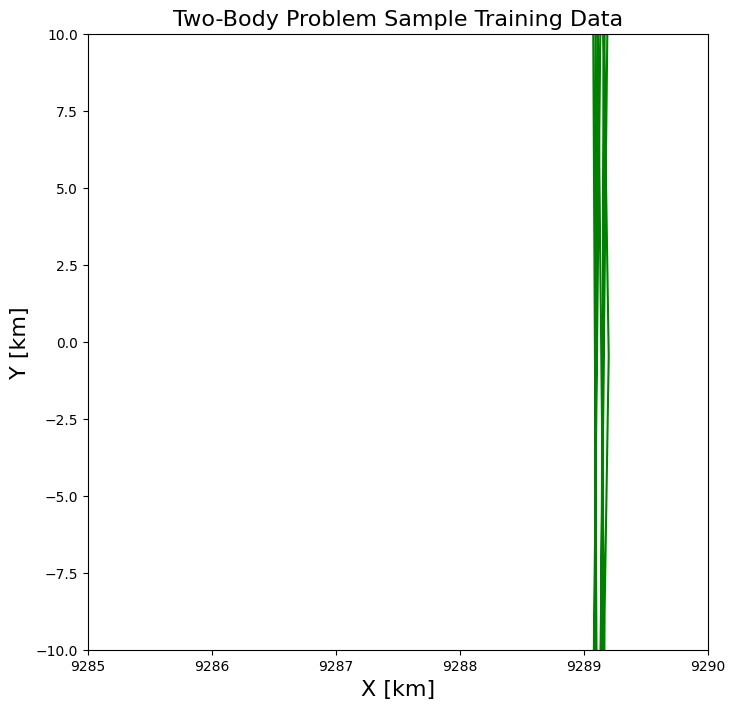

In [21]:
import numpy as np

data_x = torch.load('X_Data.pt', weights_only=False)
# Setting up Spherical Earth to Plot
N = 50
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(0, np.pi, N)
theta, phi = np.meshgrid(theta, phi)

X_Earth = r_Earth * np.cos(phi) * np.sin(theta)
Y_Earth = r_Earth * np.sin(phi) * np.sin(theta)

# Plotting Earth and Orbit
fig = plt.figure(figsize = (8,8))
ax = plt.axes()
for i in range(1):
    vec = data_x[i]
    ax.plot(vec[0,:], vec[1,:], 'green')
plt.title('Two-Body Problem Sample Training Data', fontsize=16)
ax.set_xlabel('X [km]', fontsize=16)
ax.set_ylabel('Y [km]', fontsize=16)

# Make axes limits
# xylim = np.array([ax.get_xlim(), ax.get_ylim()]).T
# XYlim = np.asarray([min(xylim[0]), max(xylim[1])])
ax.set_xlim([int(rp-4),int(rp+1)])
ax.set_ylim([-10,10])
# ax.axis('equal')
plt.show()